[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/kasparvonbeelen/ghi_python/main?labpath=12_-_Generalised_Linear_Models.ipynb)



# Lecture 12: Generalised Linear Models

## Data Science for Historians (with Python)
## A Gentle Introduction to Working with Data in Python

### Created by Kaspar Beelen and Luke Blaxill

### For the German Historical Institute, London

<img align="left" src="https://www.ghil.ac.uk/typo3conf/ext/wacon_ghil/Resources/Public/Images/institute_icon_small.png">


## Predicting Counts
### ** Under Construction (done by 10/02)**

Linear models are the bread and butter of social sciences but are also increasingly present in digital history. The models are the first option when solving a problem with statistical means, but they are not always appropriate or the best solution. Often we know something about our response variable that should be reflected in the model (so it can not make silly or irrelevant predictions). 

For example, sometimes our outcomes are discrete counts (1,2, etc) or bounded by a lower or upper limit (for example, when the outcome variable contains probabilities, each value has to be between zero and one).


This example is based on (and inspired by) the Statistical Rethinking. An excellent course into Bayesian modelling. We can not cover this topic (yet, maybe later) and continue with what's called the frequentits approach. However, the outcome will be similar.

Returning to counts.

A scenario where this often occurs is when we are modelling counts (i.e. positive integers ranging from zero, one, two, onwards) or binary response (X, not X).

In this tutorial we will be having a closer look at modelling counts that arise from binary (yes, no) process. For example modelling the number of heads after $n$ coin tosses. 


Important differences: the OLS, parameters easy interpretable in the relation to the predictions or outcomes. Linear relation easy to understand, one unit change in x leads to one unity change in y. 

Not the same for the models we will investigate below for predicting counts. Understanding and deploying GLM not as straightforward. 

We will focus on the Binomial regression to model outcomes that arise from binary trials, accept or rejections of applications. Count the number of successful or applications (or rejections)


But it also appears in many other situations, the coin toss the most common example.


## Overview

This lecture focussess on two different case-studies

- modelling gender bias on university application
- modelling gender and representation in parliamentary questions 

### The Binomial distribution


In the chapter we focus on modelling (predicting) count outcomes using a Binomial distribution.


$y ∼ Binomial(N, p)$

- $y$ the expected number of positive trials
- $N$ the number of trials
- $p$ the probababilty that an individual trial is successful

We say that $y$ is binomially distributed or more formally "the relative counts of ways to realize $y$ in $N$ trials with probability $p$ on each trial comes from the binomial distribution." (See McELreath, Statistical Rethinking 2nd Edition p. 36).

But let's unpack this sentence, and have a closer look at why the Binomial distribution is so useful for modelling various social phenonomena. 


As said earlier the Binomial distribution helps us modelling the outcomes of repeated trials. Imagine for example flipping a unbiased (p=0.5) coin 5 (N) times? What's the number of heads you expect to observe? 

We can do one experiment. In the code below we ask exactly this question.

In [162]:
np.random.seed(seed=1)
heads = binom.rvs(n=5, p=.5, size=1)
heads

array([2])

This return 2, i.e. 2 heads over 5 trials. That's possible but of of course with each experiment this number can change. Let's therefore repeat this 10 times.

In [193]:
from scipy.stats import binom

In [194]:
np.random.seed(seed=2)
heads = binom.rvs(n=5, p=.5, size=10)
heads

array([2, 0, 3, 2, 2, 2, 2, 3, 2, 2])

Each number represents the outcomes of tossing a coin five times. What we are interested in modelling is the relative number of ways each outcome occurs. 

In [204]:
np.random.seed(seed=2)
heads = binom.rvs(n=5, p=.5, size=10000)

In [205]:
heads[:10], len(heads)

(array([2, 0, 3, 2, 2, 2, 2, 3, 2, 2]), 10000)

In [206]:
hist = np.histogram(heads,bins=range(0,7))[0]
hist 

array([ 321, 1628, 3183, 2995, 1571,  302])

In [207]:
relative_counts = hist / sum(hist)
relative_counts

array([0.0321, 0.1628, 0.3183, 0.2995, 0.1571, 0.0302])

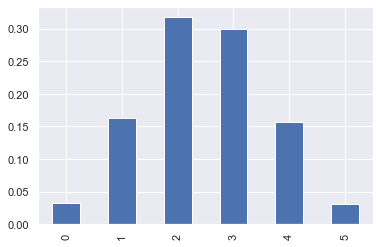

In [208]:
pd.Series(relative_counts).plot(kind='bar')

The outcomes, heads, are counts which are binomially distributed with the same probability in each toss.

In [209]:
binom(n=5,p=.5).pmf(3)

0.3125

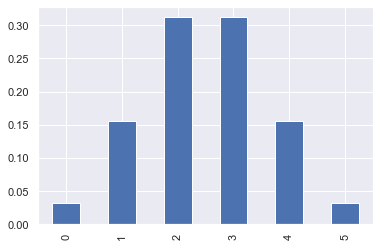

In [210]:
pd.Series(binom(n=5,p=.5).pmf([0,1,2,3,4,5])).plot(kind='bar')

Remember that in the OLS regression we simply modelling $y$ as linear combination of other intercepts and slope (or an extension thereof). This made the interpretation of the model more straightforward as the units and relations between predictor and response variables was easy to interpret.

This is different when using a Binomial. If we assume y arise from repeated trials, we can to model how $p$ varies in function of other variables, in other words "the probability of a success is related to explanatory variables" ([Wikipedia](https://en.wikipedia.org/wiki/Binomial_regression)).

$p$ however is a probability and always has to be between 0 and 1 by definition. We can not model at is a simple linear function as this a line is not guaranteed to adhere to these constriants.

In other words we can not say $y = a + b*x$ because y can (and will) easily be negative or bigger than one.

To relate the probability $p_i$ to a linear function we have to do a small trick.

$y$ ~ Binomial($N$, $p_i$) 

logit($p_i$) = $a$ + $b$*$x_i$

logit($p_i$) = log($p_i$ / (1 - $p_i$)) = $a$ + $b$*$x_i$

$p_i$ = $exp(a + b*x_i) / 1 + exp(a + b*x_i)$

### Gender bias in university admissions?

aggregated binomial

In [45]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import expit as logistic
import seaborn as sns
sns.set()

In [46]:
data = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/UCBadmit.csv',sep=';')
data.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [47]:
data = data.rename({'applicant.gender':'gender'},axis=1)

In [57]:
by_gender = data.groupby('gender')['admit','applications'].sum()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


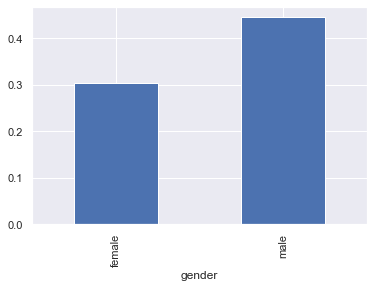

In [59]:
(by_gender['admit'] / by_gender['applications']).plot(kind='bar')

In [6]:
data['gid'] = pd.Categorical(data['gender']).codes 
data['did'] = pd.Categorical(data['dept']).codes 
data.head()

,dept,gender,admit,reject,applications,gid,did
1,A,male,512,313,825,1,0
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,0,1
5,C,male,120,205,325,1,2


In [7]:
formula = 'admit +  reject ~ C(gid)'
mod1 = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(mod1.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     ['admit', 'reject']   No. Observations:                   12
Model:                             GLM   Df Residuals:                       10
Model Family:                 Binomial   Df Model:                            1
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -426.27
Date:                 Sat, 22 Jan 2022   Deviance:                       783.61
Time:                         16:30:25   Pearson chi2:                     715.
No. Iterations:                      4                                         
Covariance Type:             nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.8305      0.051    -16

In [225]:
-0.8305 + 0.6104*1

-0.22009999999999996

In [227]:
np.exp(-0.8305 + 0.6104*0)

0.4358313161754524

In [228]:
np.exp(-0.8305 + 0.6104*1)

0.8024385500951425

In [211]:
p_0 = np.exp(-0.8305 + 0.6104 * 0) / (1 + np.exp(-0.8305 + 0.6104 * 0) )
p_1 = np.exp(-0.8305 + 0.6104 * 1) / (1 + np.exp(-0.8305 + 0.6104 * 1) )

In [212]:
p_0,p_1

(0.3035393581861365, 0.44519606510456927)

In [214]:
p_1 - p_0 

0.1416567069184328

In [213]:
mod2.predict()

array([0.44518766, 0.30354223, 0.44518766, 0.30354223, 0.44518766,
       0.30354223, 0.44518766, 0.30354223, 0.44518766, 0.30354223,
       0.44518766, 0.30354223])

In [216]:
logistic(-0.8305 + 0.6104*1) - logistic(-0.8305 + 0.6104*0)

0.1416567069184328

In [9]:
data_dummies = pd.get_dummies(data)
data_dummies

,admit,reject,applications,gid,did,dept_A,dept_B,dept_C,dept_D,dept_E,dept_F,gender_female,gender_male
1,512,313,825,1,0,1,0,0,0,0,0,0,1
2,89,19,108,0,0,1,0,0,0,0,0,1,0
3,353,207,560,1,1,0,1,0,0,0,0,0,1
4,17,8,25,0,1,0,1,0,0,0,0,1,0
5,120,205,325,1,2,0,0,1,0,0,0,0,1
6,202,391,593,0,2,0,0,1,0,0,0,1,0
7,138,279,417,1,3,0,0,0,1,0,0,0,1
8,131,244,375,0,3,0,0,0,1,0,0,1,0
9,53,138,191,1,4,0,0,0,0,1,0,0,1
10,94,299,393,0,4,0,0,0,0,1,0,1,0


In [10]:
formula = 'admit +  reject ~ gender_female + gender_male'
mod2 = smf.glm(formula=formula, data=data_dummies, family=sm.families.Binomial()).fit()
print(mod2.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     ['admit', 'reject']   No. Observations:                   12
Model:                             GLM   Df Residuals:                       10
Model Family:                 Binomial   Df Model:                            1
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -426.27
Date:                 Sat, 22 Jan 2022   Deviance:                       783.61
Time:                         16:30:26   Pearson chi2:                     715.
No. Iterations:                      7                                         
Covariance Type:             nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.3502      0.021 

In [217]:
logistic(-0.3502 + 0.1301) - logistic(-0.3502 + -0.4803) 

0.1416567069184328

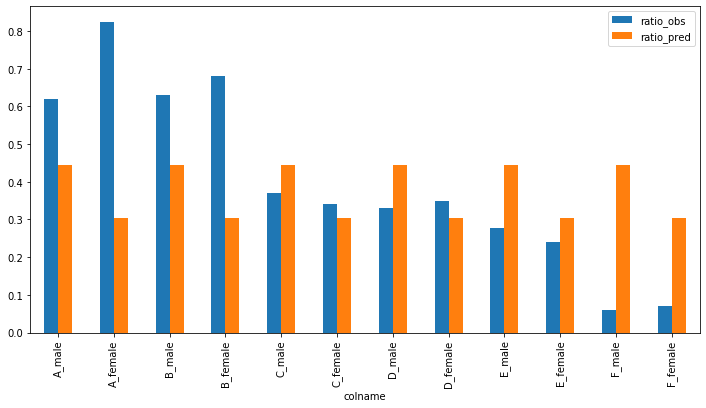

In [11]:
data['colname'] = data.apply(lambda x: x.dept + '_' + x.gender, axis=1)
data.set_index('colname',inplace=True)
data['ratio_obs'] = (data['admit'] / data['applications'])
data['ratio_pred'] = mod2.predict()
data[['ratio_obs','ratio_pred']].plot(kind='bar',figsize=(12,6),rot=90)

In [16]:
data['addm_ratio'] = data['admit'] / data['applications'] 
sns.barplot(x='dept',y='addm_ratio', hue="gender", data= data)

,admit,reject,applications,gid,did,dept_A,dept_B,dept_C,dept_D,dept_E,dept_F,gender_female,gender_male
1,512,313,825,1,0,1,0,0,0,0,0,0,1
2,89,19,108,0,0,1,0,0,0,0,0,1,0
3,353,207,560,1,1,0,1,0,0,0,0,0,1
4,17,8,25,0,1,0,1,0,0,0,0,1,0
5,120,205,325,1,2,0,0,1,0,0,0,0,1
6,202,391,593,0,2,0,0,1,0,0,0,1,0
7,138,279,417,1,3,0,0,0,1,0,0,0,1
8,131,244,375,0,3,0,0,0,1,0,0,1,0
9,53,138,191,1,4,0,0,0,0,1,0,0,1
10,94,299,393,0,4,0,0,0,0,1,0,1,0


In [18]:
formula = 'admit +  reject ~ gender_female + gender_male + C(did)'
mod3 = smf.glm(formula=formula, data=data_dummies, family=sm.families.Binomial()).fit()
print(mod3.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     ['admit', 'reject']   No. Observations:                   12
Model:                             GLM   Df Residuals:                        5
Model Family:                 Binomial   Df Model:                            6
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -44.572
Date:                 Sat, 22 Jan 2022   Deviance:                       20.204
Time:                         16:31:36   Pearson chi2:                     18.8
No. Iterations:                      6                                         
Covariance Type:             nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4213      0.050 

In [22]:
round(0.2606 - 0.1607,1)

0.1

In [23]:
round(logistic(0.2606) - logistic(0.1607),2)

0.02

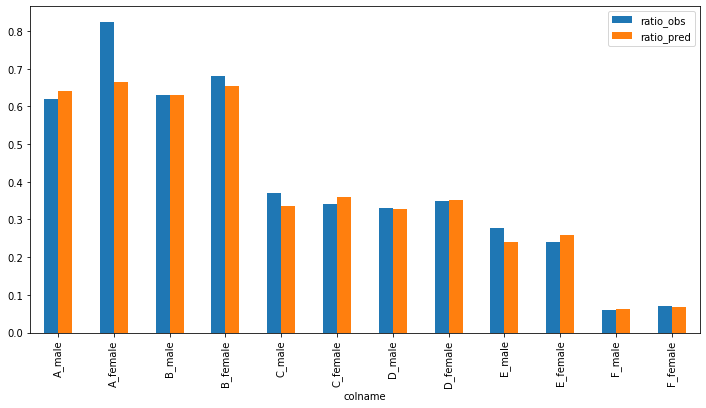

In [24]:

data['ratio_pred'] = mod3.predict()
data[['ratio_obs','ratio_pred']].plot(kind='bar',figsize=(12,6),rot=90)

## Gender and parliamentary questions

In [ ]:
#!pip3 install seaborn==0.11.2

In [60]:
df = pd.read_csv('data/questions/parl_questions.csv',index_col=0,
                 parse_dates=["dob",'date tabled'],
                date_parser= lambda x: pd.to_datetime(x, format="%Y-%m-%"))

In [ ]:
df.shape

In [66]:
df.columns

Index(['uri', 'answer date', 'answer date time', 'answering body',
       'commons question time > question type', 'location > pref label',
       'question status', 'ballot number', 'date tabled', 'modified',
       'question text', 'tabling member > label', 'tabling member > uri',
       'tabling member > constituency > pref label', 'tabling member printed',
       'uin', 'tabling member', 'gender', 'party', 'uri_mp', 'dob', 'uri_dob'],
      dtype='object')

In [61]:
df.head()

,uri,answer date,answer date time,answering body,commons question time > question type,location > pref label,question status,ballot number,date tabled,modified,...,tabling member > uri,tabling member > constituency > pref label,tabling member printed,uin,tabling member,gender,party,uri_mp,dob,uri_dob
0,http://data.parliament.uk/resources/1388433,2022-01-05,2022-01-05T00:00:00,Prime Minister,Substantive,House of Commons chamber,Tabled,5,2021-12-16,2021-12-16T14:51:06.915,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,904884.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601
1,http://data.parliament.uk/resources/1386494,2021-12-15,2021-12-15T00:00:00,Prime Minister,Substantive,House of Commons chamber,Tabled,9,2021-12-09,2021-12-15T09:09:06.008,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,904812.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601
2,http://data.parliament.uk/resources/1379254,2021-11-23,2021-11-23T00:00:00,Department of Health and Social Care,Topical,House of Commons chamber,Tabled,10,2021-11-17,2021-11-23T13:44:07.090,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,904329.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601
3,http://data.parliament.uk/resources/1351922,2021-09-06,2021-09-06T00:00:00,Department for Education,Substantive,House of Commons chamber,Tabled,9,2021-08-31,2021-09-06T15:32:44.687,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,903323.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601
4,http://data.parliament.uk/resources/1347152,2021-07-22,2021-07-22T00:00:00,"Department for Environment, Food and Rural Aff...",Substantive,House of Commons chamber,Tabled,13,2021-07-15,2021-08-18T17:06:49.789,...,http://data.parliament.uk/members/1601,Bromley and Chislehurst,Sir Robert Neill,903142.0,NaN,Male,Conservative,http://data.parliament.uk/members/1601,1952-06-24,http://data.parliament.uk/members/1601


In [88]:
df.party.unique()

array(['Conservative', 'Labour', 'Plaid Cymru', 'Labour (Co-op)',
       'Scottish National Party', 'Liberal Democrat', 'Independent',
       'Democratic Unionist Party', 'Green Party', nan,
       'The Independent Group for Change', 'Ulster Unionist Party',
       'Social Democratic & Labour Party', 'Alliance',
       'UK Independence Party'], dtype=object)

In [90]:
df = df[df.party.isin(['Conservative', 'Labour'])]

In [91]:
import re
pattern = re.compile(r'\bwoman\b|\bwomen\b|\bmother\b|\bmothers\b')
pattern.findall('woman bwomeno women. mothers.')

['woman', 'women', 'mothers']

In [97]:

df['about_woman'] = df['question text'].apply(lambda x: int(bool(pattern.findall(str(x).lower()))))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [98]:
df['about_woman'].value_counts()

0    27807
1      396
Name: about_woman, dtype: int64

In [99]:
df[['gender_Female','gender_Male','party_Conservative','party_Labour']] =pd.get_dummies(df[['gender','party']])

In [100]:
formula = 'about_woman ~ gender_Female + party_Conservative'
mod1 = smf.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            about_woman   No. Observations:                28203
Model:                            GLM   Df Residuals:                    28200
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2043.0
Date:                Sat, 22 Jan 2022   Deviance:                       4085.9
Time:                        17:01:41   Pearson chi2:                 2.82e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.6601      0

In [113]:
df_agg = df.groupby(['uri_mp','gender_Female','party_Conservative']).agg({'about_woman':'sum','uri':'count'}).reset_index()

In [114]:
df_agg['not_about'] = df_agg['uri'] - df_agg['about_woman']

In [117]:
formula = 'about_woman +  not_about ~ gender_Female + party_Conservative'
mod3 = smf.glm(formula=formula, data=df_agg, family=sm.families.Binomial()).fit()
print(mod3.summary())

                      Generalized Linear Model Regression Results                       
Dep. Variable:     ['about_woman', 'not_about']   No. Observations:                  527
Model:                                      GLM   Df Residuals:                      524
Model Family:                          Binomial   Df Model:                            2
Link Function:                            logit   Scale:                          1.0000
Method:                                    IRLS   Log-Likelihood:                -494.72
Date:                          Sat, 22 Jan 2022   Deviance:                       533.40
Time:                                  17:13:40   Pearson chi2:                     518.
No. Iterations:                               8                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

In [121]:
formula = 'about_woman ~ gender_Female + party_Conservative'
mod3 = smf.glm(formula=formula, data=df_agg, family=sm.families.Poisson()).fit()
print(mod3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            about_woman   No. Observations:                  527
Model:                            GLM   Df Residuals:                      524
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -608.17
Date:                Sat, 22 Jan 2022   Deviance:                       543.69
Time:                        17:15:19   Pearson chi2:                     753.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.6943      0

In [107]:
logistic(0.9337) - logistic(0)

0.2178253320016068

In [101]:
df['answering_body_code'] = pd.Categorical(df['answering body']).codes

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [103]:
formula = 'about_woman ~ gender_Female + party_Conservative + C(answering_body_code)'
mod1 = smf.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            about_woman   No. Observations:                28203
Model:                            GLM   Df Residuals:                    28159
Model Family:                Binomial   Df Model:                           43
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1353.9
Date:                Sat, 22 Jan 2022   Deviance:                       2707.8
Time:                        17:03:25   Pearson chi2:                 1.90e+04
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [104]:
logistic(0.6443) - logistic(0)

0.15572483359492084